In [1]:
import pickle
import pandas as pd
import numpy as np
from sklearn.metrics import precision_recall_curve, roc_auc_score, confusion_matrix, precision_score, recall_score
from sklearn.model_selection import KFold, StratifiedKFold
from scipy.stats.mstats import gmean
import xgboost as xgb
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
fpath = "/Users/ys8mz/Box Sync/Predictive Models of College Completion (VCCS)/intermediate_files"

In [2]:
df = pd.read_stata(fpath + "/full_data_truncated_alternative.dta")

In [3]:
# Drop NSC predictors from the list
nsc_predictors = ['pre_num_nsc_coll', 'num_nsc_coll', 'pre_nsc_terms', 'nsc_terms', 
                  'enrolled_nsc','admrate','gradrate','satvr25','satvr75','satmt25', 'satmt75','satwr25','satwr75',
                  'nsc_coll_type_1', 'nsc_coll_type_2', 'nsc_coll_type_3', 'nsc_coll_type_4',
                  'nsc_coll_type_5','nsc_coll_type_6','nsc_coll_type_7', 'nsc_coll_type_8'] + \
                 [e1+e2+str(e3) for e1 in ['enrolled_nsc_', 'enrl_intensity_nsc_'] for e2 in ['fa','su','sp'] for e3 in range(1,7)]
predictors = np.setdiff1d(list(df.columns.values)[10:], nsc_predictors)
print(len(predictors))

274


In [4]:
impute_list_1 = set(["prop_comp_pre","cum_gpa_pre"])
impute_list_2 = set([t1+"_"+t2+str(t3) for t1 in ["term_gpa", "prop_comp", "lvl2_prop_comp", "dev_prop_comp"] for t2 in ["fa", "sp", "su"] for t3 in range(1,7,1)])
impute_list_3 = set(["cum_gpa", "lvl2_prop_comp", "dev_prop_comp", "prop_comp", "prop_comp_sd", "withdrawn_prop_comp_sd"])
impute_list_4 = set(["admrate", "gradrate", "satvr25", "satvr75", "satmt25", "satmt75", "satwr25", "satwr75"])

In [5]:
train_df = df[df.valid == 0]
test_df = df[df.valid == 1]
print(train_df.shape,test_df.shape)

(298624, 341) (33161, 341)


In [6]:
# degree completion rate of validation sample
sum(train_df.grad_vccs_6years)/train_df.shape[0]

0.23733189562794685

In [7]:
# degree completion rate of validation sample
sum(test_df.grad_vccs_6years)/test_df.shape[0]

0.23753807183136819

In [8]:
def impute(train, test):
    for p in impute_list_1:
        avg_p = np.nanmean(train[train.enrolled_pre == 1][p])
        train.loc[:,p] = train.loc[:,p].apply(lambda x: avg_p if pd.isnull(x) else x)
        test.loc[:,p] = test.loc[:,p].apply(lambda x: avg_p if pd.isnull(x) else x)
    for p in impute_list_3:
        avg_p = np.nanmean(train[p])
        train.loc[:,p] = train.loc[:,p].apply(lambda x: avg_p if pd.isnull(x) else x)
        test.loc[:,p] = test.loc[:,p].apply(lambda x: avg_p if pd.isnull(x) else x)
    for p in impute_list_2:
        suffix = p[-3:]
        avg_p = np.nanmean(train[train["enrolled_" + suffix] == 1][p])
        train.loc[:,p] = train.loc[:,p].apply(lambda x: avg_p if pd.isnull(x) else x)
        test.loc[:,p] = test.loc[:,p].apply(lambda x: avg_p if pd.isnull(x) else x)
    for p in impute_list_4:
        avg_p = np.nanmean(train[train["enrolled_nsc"] == 1][p])
        train.loc[:,p] = train.loc[:,p].apply(lambda x: avg_p if pd.isnull(x) else x)
        test.loc[:,p] = test.loc[:,p].apply(lambda x: avg_p if pd.isnull(x) else x)
    return train, test 

In [9]:
train_df_new, test_df_new = impute(train_df, test_df)
X_train = train_df_new.loc[:,predictors]
y_train = train_df_new.grad_6years
X_test = test_df_new.loc[:,predictors]
y_test = test_df_new.grad_6years

C:\Users\ys8mz\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [10]:
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)

In [11]:
np.random.seed(4321)
val_indices = np.random.choice(train_df.shape[0], int(np.floor(train_df.shape[0]*0.15)), replace=False)
train_val = train_df.iloc[val_indices,:]
train_train = train_df.iloc[np.setdiff1d(np.arange(train_df.shape[0]), val_indices),:]
train_train_new, train_val_new = impute(train_train, train_val)
X_train_train = train_train_new.loc[:,predictors]
y_train_train = train_train_new.grad_6years
X_train_val = train_val_new.loc[:,predictors]
y_train_val = train_val_new.grad_6years

C:\Users\ys8mz\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [12]:
dtrain_train = xgb.DMatrix(X_train_train, y_train_train)
dtrain_val = xgb.DMatrix(X_train_val, y_train_val)

In [13]:
results_dir = "C:\\Users\\ys8mz\\Box Sync\\Predictive Models of College Completion (VCCS)\\evaluation_results\\truncated_new_5\\"

#### (1) Grid Search for max_depth and eta (learning rate)

In [17]:
grid_1 = [(md,e) for md in range(4,8) for e in [0.01, 0.02, 0.05, 0.1, 0.2]]
validation_auc_1 = Counter()
for md,e in grid_1:
    print("max_depth = {0}, eta = {1}:".format(md,e))
    params = {'max_depth': md, 'eta': e, 'min_child_weight': 1, 'colsample_bytree': 0.8, 
              'subsample': 0.8, 
              'objective': 'binary:logistic', 'eval_metric': ['auc'],
              'seed': 12345}
    evals_result = {}
    xgb_model = xgb.train(params = params, dtrain = dtrain_train, num_boost_round = int(5e3), evals = [(dtrain_val, 'validation')],
                          early_stopping_rounds = 10,
                          evals_result = evals_result,
                          verbose_eval = 50)
    validation_auc_1[(md,e)] = np.max(evals_result['validation']['auc'])
    print("")

max_depth = 4, eta = 0.01:
[0]	validation-auc:0.851236
Will train until validation-auc hasn't improved in 10 rounds.
[50]	validation-auc:0.881727
[100]	validation-auc:0.887398
[150]	validation-auc:0.892363
[200]	validation-auc:0.895502
[250]	validation-auc:0.898148
[300]	validation-auc:0.90057
[350]	validation-auc:0.902835
[400]	validation-auc:0.904661
[450]	validation-auc:0.906412
[500]	validation-auc:0.907981
[550]	validation-auc:0.909355
[600]	validation-auc:0.910614
[650]	validation-auc:0.911825
[700]	validation-auc:0.912811
[750]	validation-auc:0.913688
[800]	validation-auc:0.914585
[850]	validation-auc:0.915455
[900]	validation-auc:0.916083
[950]	validation-auc:0.916669
[1000]	validation-auc:0.917207
[1050]	validation-auc:0.917679
[1100]	validation-auc:0.918175
[1150]	validation-auc:0.918654
[1200]	validation-auc:0.919055
[1250]	validation-auc:0.919493
[1300]	validation-auc:0.919872
[1350]	validation-auc:0.920337
[1400]	validation-auc:0.920666
[1450]	validation-auc:0.921047
[1500

[1300]	validation-auc:0.924015
[1350]	validation-auc:0.924396
[1400]	validation-auc:0.924699
[1450]	validation-auc:0.924963
[1500]	validation-auc:0.925184
[1550]	validation-auc:0.925431
[1600]	validation-auc:0.9257
[1650]	validation-auc:0.925928
[1700]	validation-auc:0.926143
[1750]	validation-auc:0.926351
[1800]	validation-auc:0.926542
[1850]	validation-auc:0.926748
[1900]	validation-auc:0.926887
[1950]	validation-auc:0.927043
[2000]	validation-auc:0.9272
[2050]	validation-auc:0.927314
[2100]	validation-auc:0.927448
[2150]	validation-auc:0.9276
[2200]	validation-auc:0.927709
[2250]	validation-auc:0.927826
[2300]	validation-auc:0.927948
[2350]	validation-auc:0.92807
[2400]	validation-auc:0.928224
[2450]	validation-auc:0.928337
[2500]	validation-auc:0.928446
[2550]	validation-auc:0.928532
[2600]	validation-auc:0.928632
[2650]	validation-auc:0.928717
[2700]	validation-auc:0.928836
[2750]	validation-auc:0.92893
[2800]	validation-auc:0.929041
[2850]	validation-auc:0.929132
[2900]	validatio

[1100]	validation-auc:0.92995
[1150]	validation-auc:0.930171
[1200]	validation-auc:0.930371
[1250]	validation-auc:0.930538
[1300]	validation-auc:0.93066
[1350]	validation-auc:0.930823
[1400]	validation-auc:0.930966
[1450]	validation-auc:0.931091
[1500]	validation-auc:0.931233
[1550]	validation-auc:0.931393
Stopping. Best iteration:
[1577]	validation-auc:0.931466


max_depth = 6, eta = 0.05:
[0]	validation-auc:0.877241
Will train until validation-auc hasn't improved in 10 rounds.
[50]	validation-auc:0.909206
[100]	validation-auc:0.917184
[150]	validation-auc:0.921963
[200]	validation-auc:0.924618
[250]	validation-auc:0.926525
[300]	validation-auc:0.927617
[350]	validation-auc:0.928475
[400]	validation-auc:0.929152
[450]	validation-auc:0.929825
[500]	validation-auc:0.930246
[550]	validation-auc:0.930698
[600]	validation-auc:0.931036
[650]	validation-auc:0.931449
[700]	validation-auc:0.93172
[750]	validation-auc:0.931983
Stopping. Best iteration:
[770]	validation-auc:0.932051


max_depth 

In [18]:
for t in validation_auc_1.most_common():
    print(t)

((7, 0.02), 0.93317)
((7, 0.05), 0.933036)
((7, 0.01), 0.932824)
((6, 0.05), 0.932051)
((6, 0.01), 0.931827)
((5, 0.02), 0.931806)
((6, 0.02), 0.931466)
((7, 0.1), 0.931377)
((5, 0.01), 0.931042)
((5, 0.1), 0.930821)
((4, 0.1), 0.930645)
((6, 0.1), 0.930583)
((5, 0.05), 0.930567)
((4, 0.02), 0.930447)
((7, 0.2), 0.930135)
((6, 0.2), 0.930107)
((4, 0.05), 0.930026)
((4, 0.2), 0.929389)
((5, 0.2), 0.929)
((4, 0.01), 0.92896)


#### (2) Grid Search for min_child_weight (along with max_depth)

In [19]:
md1 = 6
grid_2 = [(md1+i,mcw) for i in [-1,0,1] for mcw in [3,5]]
validation_auc_2 = Counter()
for md,mcw in grid_2:
    print("max_depth = {0}, min_child_weight = {1}:".format(md,mcw))
    params = {'max_depth': md, 'eta': 0.02, 'min_child_weight': mcw, 'colsample_bytree': 0.8, 
              'subsample': 0.8, 
              'objective': 'binary:logistic', 'eval_metric': ['auc'],
              'seed': 12345}
    evals_result = {}
    xgb_model = xgb.train(params = params, dtrain = dtrain_train, num_boost_round = int(5e3), evals = [(dtrain_val, 'validation')],
                          early_stopping_rounds = 10,
                          evals_result = evals_result,
                          verbose_eval = 50)
    validation_auc_2[(md,mcw)] = np.max(evals_result['validation']['auc'])
    print("")

max_depth = 5, min_child_weight = 3:
[0]	validation-auc:0.865927
Will train until validation-auc hasn't improved in 10 rounds.
[50]	validation-auc:0.895307
[100]	validation-auc:0.902206
[150]	validation-auc:0.906666
[200]	validation-auc:0.910183
[250]	validation-auc:0.913336
[300]	validation-auc:0.91591
[350]	validation-auc:0.917826
[400]	validation-auc:0.919329
[450]	validation-auc:0.92065
[500]	validation-auc:0.921657
[550]	validation-auc:0.922569
[600]	validation-auc:0.923361
[650]	validation-auc:0.924115
[700]	validation-auc:0.924919
[750]	validation-auc:0.925481
[800]	validation-auc:0.925858
[850]	validation-auc:0.926281
[900]	validation-auc:0.926684
[950]	validation-auc:0.926969
[1000]	validation-auc:0.927354
[1050]	validation-auc:0.927679
[1100]	validation-auc:0.927908
[1150]	validation-auc:0.928192
[1200]	validation-auc:0.9284
[1250]	validation-auc:0.92861
[1300]	validation-auc:0.928794
[1350]	validation-auc:0.92897
[1400]	validation-auc:0.9291
[1450]	validation-auc:0.929248
[1

In [20]:
for t in validation_auc_2.most_common():
    print(t)

((7, 3), 0.932584)
((6, 3), 0.932345)
((7, 5), 0.932341)
((5, 3), 0.931552)
((6, 5), 0.931263)
((5, 5), 0.930457)


#### (3) Grid Search for colsample_by_tree

In [21]:
grid_3 = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]
validation_auc_3 = Counter()
for cbt in grid_3:
    print("colsample_by_tree = {}:".format(cbt))
    params = {'max_depth': 7, 'eta': 0.02, 'min_child_weight': 3, 'colsample_bytree': cbt, 
              'subsample': 0.8, 
              'objective': 'binary:logistic', 'eval_metric': ['auc'],
              'seed': 12345}
    evals_result = {}
    xgb_model = xgb.train(params = params, dtrain = dtrain_train, num_boost_round = int(5e3), evals = [(dtrain_val, 'validation')],
                          early_stopping_rounds = 10,
                          evals_result = evals_result,
                          verbose_eval = 50)
    validation_auc_3[cbt] = np.max(evals_result['validation']['auc'])
    print("")

colsample_by_tree = 0.5:
[0]	validation-auc:0.878196
Will train until validation-auc hasn't improved in 10 rounds.
[50]	validation-auc:0.908325
[100]	validation-auc:0.912962
[150]	validation-auc:0.916228
[200]	validation-auc:0.918759
[250]	validation-auc:0.920748
[300]	validation-auc:0.922436
[350]	validation-auc:0.923861
[400]	validation-auc:0.924959
[450]	validation-auc:0.925993
[500]	validation-auc:0.926755
[550]	validation-auc:0.927482
[600]	validation-auc:0.928016
[650]	validation-auc:0.928471
[700]	validation-auc:0.928932
[750]	validation-auc:0.929268
[800]	validation-auc:0.929569
[850]	validation-auc:0.929835
[900]	validation-auc:0.930042
[950]	validation-auc:0.930279
[1000]	validation-auc:0.930539
[1050]	validation-auc:0.930777
[1100]	validation-auc:0.930947
[1150]	validation-auc:0.931143
[1200]	validation-auc:0.931266
[1250]	validation-auc:0.931428
[1300]	validation-auc:0.931589
[1350]	validation-auc:0.931677
[1400]	validation-auc:0.931841
Stopping. Best iteration:
[1422]	vali

[700]	validation-auc:0.929148
[750]	validation-auc:0.92951
[800]	validation-auc:0.929872
[850]	validation-auc:0.930157
[900]	validation-auc:0.930479
[950]	validation-auc:0.930753
[1000]	validation-auc:0.930977
[1050]	validation-auc:0.93122
[1100]	validation-auc:0.931453
[1150]	validation-auc:0.931655
[1200]	validation-auc:0.9318
[1250]	validation-auc:0.931936
[1300]	validation-auc:0.932064
[1350]	validation-auc:0.932169
[1400]	validation-auc:0.93226
[1450]	validation-auc:0.932375
[1500]	validation-auc:0.932489
Stopping. Best iteration:
[1522]	validation-auc:0.932548


colsample_by_tree = 0.9:
[0]	validation-auc:0.883979
Will train until validation-auc hasn't improved in 10 rounds.
[50]	validation-auc:0.905733
[100]	validation-auc:0.911698
[150]	validation-auc:0.915188
[200]	validation-auc:0.918053
[250]	validation-auc:0.920473
[300]	validation-auc:0.92257
[350]	validation-auc:0.924025
[400]	validation-auc:0.925076
[450]	validation-auc:0.926165
[500]	validation-auc:0.927034
[550]	valida

In [23]:
validation_auc_3.most_common()

[(0.65, 0.933173),
 (0.8, 0.932584),
 (0.7, 0.932582),
 (0.85, 0.932548),
 (0.75, 0.932421),
 (0.9, 0.932387),
 (0.55, 0.932262),
 (0.6, 0.932246),
 (0.5, 0.931865)]

#### (4) Finally select the opitmal num_boost_round

In [24]:
params = {'max_depth': 7, 'eta': 0.02, 'min_child_weight': 3, 'colsample_bytree': 0.8, 
          'subsample': 0.8, 
          'objective': 'binary:logistic', 'eval_metric': ['auc'],
          'seed': 12345}
evals_result = {}
xgb_model = xgb.train(params = params, dtrain = dtrain_train, num_boost_round = int(5e3), evals = [(dtrain_val, 'validation')],
                      early_stopping_rounds = 10,
                      evals_result = evals_result,
                      verbose_eval = 50)
optimal_num_boost_round = np.argmax(evals_result['validation']['auc'])
print("")
print(optimal_num_boost_round)

[0]	validation-auc:0.883182
Will train until validation-auc hasn't improved in 10 rounds.
[50]	validation-auc:0.906868
[100]	validation-auc:0.91215
[150]	validation-auc:0.915474
[200]	validation-auc:0.918203
[250]	validation-auc:0.920367
[300]	validation-auc:0.922477
[350]	validation-auc:0.923834
[400]	validation-auc:0.924929
[450]	validation-auc:0.925981
[500]	validation-auc:0.926748
[550]	validation-auc:0.927526
[600]	validation-auc:0.928072
[650]	validation-auc:0.928627
[700]	validation-auc:0.929091
[750]	validation-auc:0.929424
[800]	validation-auc:0.929741
[850]	validation-auc:0.930002
[900]	validation-auc:0.930358
[950]	validation-auc:0.930606
[1000]	validation-auc:0.930845
[1050]	validation-auc:0.931086
[1100]	validation-auc:0.931312
[1150]	validation-auc:0.931547
[1200]	validation-auc:0.931661
[1250]	validation-auc:0.931812
[1300]	validation-auc:0.931971
[1350]	validation-auc:0.932064
[1400]	validation-auc:0.93215
[1450]	validation-auc:0.932256
[1500]	validation-auc:0.932386
[1

#### (5) Train the final xgb model and make predictions for observations in the test set

In [25]:
# specify parameters via map
params = {'max_depth': 7, 'eta': 0.02, 'min_child_weight': 3, 'colsample_bytree': 0.8, 
          'subsample': 0.8, 
          'objective': 'binary:logistic', 'eval_metric': ['auc'],
          'seed': 12345}
final_xgb_model = xgb.train(params = params, dtrain = dtrain, num_boost_round = optimal_num_boost_round)
# make prediction for observations in the test set
y_test_pred = final_xgb_model.predict(dtest)

In [26]:
print("XGBoost:")
print("AUC = {}".format(round(roc_auc_score(dtest.get_label(), y_test_pred), 4)))

XGBoost:
AUC = 0.933


In [27]:
# save the model object and predicted scores on the validation sample to local disk
# pickle.dump(final_xgb_model, open(results_dir + "xgb.p", "wb"))
pickle.dump(list(y_test_pred), open(results_dir + "y_test_pred_xgb.p", "wb"))

In [28]:
feature_importance = pd.DataFrame(list(final_xgb_model.get_fscore().items()), columns=['feature','importance']).sort_values('importance', ascending=False)
feature_importance.loc[:, 'importance'] = feature_importance.loc[:, 'importance'] / sum(feature_importance.loc[:, 'importance'])
yy = feature_importance.loc[:, 'importance'].iloc[:20]
xx = feature_importance.loc[:, 'feature'].iloc[:20]

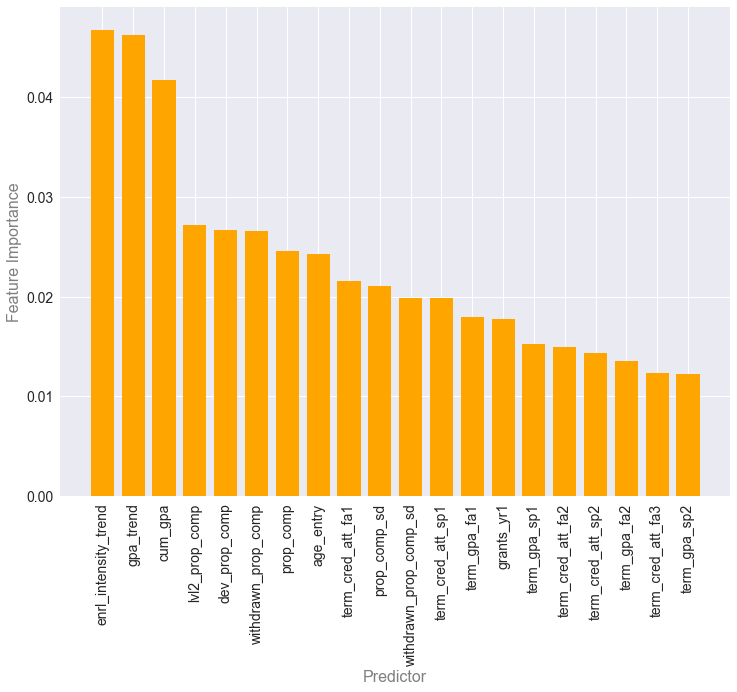

In [30]:
fig = plt.figure(figsize=(12,9))
plt.bar(list(range(20)), yy, width=0.75, color = "orange")
plt.xticks(list(range(20)), xx, rotation = 'vertical', fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Predictor", fontsize=16, color="gray")
plt.ylabel("Feature Importance", fontsize=16, color="gray")
plt.savefig(results_dir + "XGBoost_variable_importance.png", bbox_inches='tight')
plt.show()

In [31]:
def find_optimal_threshold(p,r,t):
    to_drop = np.union1d(np.where(pd.isnull(p[:-1]) == True)[0], np.where(pd.isnull(r[:-1]) == True)[0])
    to_drop = np.union1d(to_drop, np.where(pd.isnull(t) == True)[0])
    to_keep = np.setdiff1d(np.array(list(range(len(p)-1))), to_drop)
    p,r,t = p[to_keep],r[to_keep],t[to_keep]
    f1 = 2*p*r/(p+r)
    best_t = t[np.argmax(f1)]
    best_t
    return best_t

def cross_validation(train, xgb_params, nbr):
    threshold_list = []
    auc_list = []
    k_fold =  StratifiedKFold(n_splits = 10, random_state = 12345, shuffle=True)
    for train_indices, test_indices in k_fold.split(train, train.grad_6years):
        train_part = train.iloc[train_indices,:]
        test_part = train.iloc[test_indices,:]
        train_part_new, test_part_new = impute(train_part, test_part)
        X_1 = train_part_new.loc[:,predictors]
        y_1 = train_part_new.grad_6years
        X_2 = test_part_new.loc[:,predictors]
        y_2 = test_part_new.grad_6years
        dtrain_cv = xgb.DMatrix(X_1,y_1)
        dtest_cv = xgb.DMatrix(X_2,y_2)
        xgb_cv_model = xgb.train(params=xgb_params, dtrain=dtrain_cv, num_boost_round = nbr)
        y_2_pred = xgb_cv_model.predict(dtest_cv)
        p,r,t = precision_recall_curve(y_2, y_2_pred)
        auc = roc_auc_score(y_2, y_2_pred)
        threshold_list.append(find_optimal_threshold(p,r,t))
        auc_list.append(auc)
    print(np.mean(auc_list), np.std(auc_list, ddof=1))
    return gmean(threshold_list)

In [32]:
final_params = {'max_depth': 7, 'eta': 0.02, 'min_child_weight': 3, 'colsample_bytree': 0.8, 
                'subsample': 0.8, 
                'objective': 'binary:logistic', 'eval_metric': ['auc'],
                'seed': 12345}
best_threshold = cross_validation(train_df, final_params, optimal_num_boost_round)

C:\Users\ys8mz\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\ys8mz\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\ys8mz\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

0.9319076316298072 0.0013108900617358728


In [33]:
best_threshold

0.38493904

In [34]:
def create_confusion_matrix(y_test_pred, threshold, fname):
    cm_arr = confusion_matrix(y_test, np.where(y_test_pred > threshold, 1, 0))
    cm_df = pd.DataFrame(cm_arr, columns=['Pred_0','Pred_1'], index=['Real_0', 'Real_1'])
    cm_df.loc[:,''] = cm_df.sum(axis=1)
    cm_df.loc['',:] = cm_df.sum(axis=0)
    print(cm_df)
    print("")
    p1 = cm_df.iloc[1,1]/cm_df.iloc[2,1]
    r1 = cm_df.iloc[1,1]/cm_df.iloc[1,2]
    p0 = cm_df.iloc[0,0]/cm_df.iloc[2,0]
    r0 = cm_df.iloc[0,0]/cm_df.iloc[0,2]    
    print("F1 score = {}".format(round(2*p1*r1/(p1+r1),4)))    
    cm_df.to_csv(results_dir + fname + ".csv")
    return p1,r1,p0,r0,round(2*p1*r1/(p1+r1),4)

In [35]:
print("F1 threshold = {}:\n".format(str(round(best_threshold,3))))
pr_xgb = create_confusion_matrix(y_test_pred, best_threshold, "XGBoost_cm1")

F1 threshold = 0.385:

         Pred_0  Pred_1         
Real_0  22679.0  2605.0  25284.0
Real_1   1619.0  6258.0   7877.0
        24298.0  8863.0  33161.0

F1 score = 0.7477


In [36]:
num_of_0 = int(round((1-np.mean(train_df.grad_6years))*len(y_test)))
y_test_pred_binary = np.ones(len(y_test))
y_test_pred_binary[np.argsort(y_test_pred)[:num_of_0]] = 0
alternative_threshold = y_test_pred[np.argsort(y_test_pred)[num_of_0]]
print("Alternative threshold = {}:\n".format(str(round(alternative_threshold,3))))
pr2_xgb = create_confusion_matrix(y_test_pred_binary, best_threshold, "XGBoost_cm2")

Alternative threshold = 0.458:

         Pred_0  Pred_1         
Real_0  23238.0  2046.0  25284.0
Real_1   2053.0  5824.0   7877.0
        25291.0  7870.0  33161.0

F1 score = 0.7397


In [37]:
precision_recall_df = pd.DataFrame([(best_threshold,)+pr_xgb,(alternative_threshold,)+pr2_xgb]).round(4)
precision_recall_df.index = ['F1','Same_Graduation_Rate']
precision_recall_df.columns = ['threshold','precision_1','recall_1','precision_0','recall_0','f1_score']
precision_recall_df.to_csv(results_dir + "XGBoost_precision_recall.csv", index=True)

#### Reorganize files of key evaluation metrics for the five models fitted on the training sample without incorporating NSC data (alternative outcome definition): OLS, Logit, RF, XGBoost, CoxPH

In [14]:
# Key evaluation metrics used to generate Appendix Figure A29 of the paper
cstat = [0.9095,0.9011,0.9079,0.9138,0.933]
m_dict = {'Logit': 'LR1', 'OLS': 'OLS',
          'RF': 'RF', 'XGBoost': 'XGBoost',
          'CoxPH': 'Cox'}
m_list = ['Logit', 'OLS', 'CoxPH', 'RF', 'XGBoost']
summary = []
for c,m in zip(cstat,m_list):
    summary.append((m,c)+tuple(pd.read_csv(results_dir + "\\{}_precision_recall.csv".format(m_dict[m])).iloc[0,1:]))
summary_df = pd.DataFrame(summary, columns=['model','c-statistic','threshold','precision_1','recall_1',
                                            'precision_0','recall_0','f1_score_1'])
summary_df.loc[:,'f1_score_0'] = 2*summary_df.precision_0*summary_df.recall_0/(summary_df.precision_0+summary_df.recall_0)
summary_df.loc[:,'f1_score_0'] = summary_df.loc[:,'f1_score_0'].apply(lambda x: round(x,4))
summary_df.to_csv(results_dir + "cleaned_results\\main_eval_metrics.csv", index=False)

In [15]:
import os
os.chdir("C:\\Users\\ys8mz\\Box Sync\\Predictive Models of College Completion (VCCS)\\evaluation_results\\truncated_new_5")

In [16]:
# save the predicted scores of all without-NSC-data models into a single table, for easier retrieval in subsequent steps
pred_score_dict = {}
m2_dict = {'lr':'Logit','xgb':'XGBoost','ols':'OLS','rf':'RF','cox':'CoxPH'}
for k,v in m2_dict.items():
    pred_score_dict[v] = pickle.load(open(results_dir+"y_test_pred_{}.p".format(k), "rb"))
pd.DataFrame(pred_score_dict, index=list(test_df.vccsid)).sort_index().to_csv(results_dir+"cleaned_results\\all_pred_scores.csv")